In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import preprocessing
import statsmodels.api as sm
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import patsy
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline

In [39]:
class LogitRegression(LinearRegression):

    def fit(self, x, p):
        p = np.asarray(p)
        y = np.log(p / (1 - p))
        return super().fit(x, y)

    def predict(self, x):
        y = super().predict(x)
        return 1 / (np.exp(-y) + 1)

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [4]:
df = pd.read_csv("Data/county_data_clean.csv")

#### Dataframe for State and Counties

In [5]:
df_states = df[df["county_fips_code"] == 0] #Dataframe for states only
df_counties = df[df["county_fips_code"] != 0] #Dataframe for counties only

In [6]:
df_counties = df_counties.set_index("name")
df_states = df_states.set_index("name")

In [7]:
df_counties = df_counties.drop(["Unnamed: 0"], axis=1)
df_states = df_states.drop(["Unnamed: 0"], axis=1)

In [8]:
df_counties["insured_adults_raw"] = df_counties["adult_population_18_64"] - df_counties["uninsured_adults_raw"]

#### Dropping columns

In [9]:
df_counties = df_counties.drop(["Kalawao County"]) # Only NA's in response variable

In [10]:
df_counties = df_counties.drop(["state_fips_code", "state_abbreviation", "county_fips_code", "5_digit_fips_code"], axis = 1)

In [11]:
df_counties.shape #3142 counties, 154 columns

(3141, 154)

In [12]:
df_counties.isna().mean().sort_values(ascending = True)

insured_adults_raw                                                      0.000000
uninsured_children                                                      0.000000
adult_population_18_64                                                  0.000000
uninsured_adults_raw                                                    0.000000
uninsured_adults                                                        0.000000
insufficient_sleep                                                      0.000000
food_insecurity                                                         0.000000
diabetes_prevalence                                                     0.000000
frequent_mental_distress                                                0.000000
frequent_physical_distress                                              0.000000
median_household_income                                                 0.000000
some_college                                                            0.000000
children_in_poverty         

In [13]:
df_counties.columns[df_counties.columns.str.endswith('_black')]

Index(['premature_death_black', 'low_birthweight_black', 'teen_births_black',
       'preventable_hospital_stays_black', 'mammography_screening_black',
       'flu_vaccinations_black', 'children_in_poverty_black',
       'driving_alone_to_work_black', 'life_expectancy_black',
       'premature_age_adjusted_mortality_black', 'child_mortality_black',
       'infant_mortality_black', 'median_household_income_black'],
      dtype='object')

In [14]:
df_counties.columns[df_counties.columns.str.endswith('_white')]

Index(['premature_death_white', 'low_birthweight_white', 'teen_births_white',
       'preventable_hospital_stays_white', 'mammography_screening_white',
       'flu_vaccinations_white', 'children_in_poverty_white',
       'driving_alone_to_work_white', 'life_expectancy_white',
       'premature_age_adjusted_mortality_white', 'child_mortality_white',
       'infant_mortality_white', 'median_household_income_white',
       'residential_segregation_black_white',
       'residential_segregation_non_white_white',
       'percent_non_hispanic_white'],
      dtype='object')

In [15]:
df_counties.columns[df_counties.columns.str.endswith('_hispanic')]

Index(['premature_death_hispanic', 'low_birthweight_hispanic',
       'teen_births_hispanic', 'preventable_hospital_stays_hispanic',
       'mammography_screening_hispanic', 'flu_vaccinations_hispanic',
       'children_in_poverty_hispanic', 'driving_alone_to_work_hispanic',
       'life_expectancy_hispanic', 'premature_age_adjusted_mortality_hispanic',
       'child_mortality_hispanic', 'infant_mortality_hispanic',
       'median_household_income_hispanic', 'percent_hispanic'],
      dtype='object')

In [16]:
df_counties = df_counties.drop(['premature_death_black', 'low_birthweight_black', 'teen_births_black',
                                'preventable_hospital_stays_black', 'mammography_screening_black',
                                'flu_vaccinations_black', 'children_in_poverty_black',
                                'driving_alone_to_work_black', 'life_expectancy_black',
                                'premature_age_adjusted_mortality_black', 'child_mortality_black',
                                'infant_mortality_black', 'median_household_income_black', 
                                'premature_death_white', 'low_birthweight_white', 'teen_births_white',
                                'preventable_hospital_stays_white', 'mammography_screening_white',
                                'flu_vaccinations_white', 'children_in_poverty_white',
                                'driving_alone_to_work_white', 'life_expectancy_white',
                                'premature_age_adjusted_mortality_white', 'child_mortality_white',
                                'infant_mortality_white', 'median_household_income_white',
                                'premature_death_hispanic', 'low_birthweight_hispanic',
                                'teen_births_hispanic', 'preventable_hospital_stays_hispanic',
                                'mammography_screening_hispanic', 'flu_vaccinations_hispanic',
                                'children_in_poverty_hispanic', 'driving_alone_to_work_hispanic',
                                'life_expectancy_hispanic', 'premature_age_adjusted_mortality_hispanic',
                                'child_mortality_hispanic', 'infant_mortality_hispanic',
                                'median_household_income_hispanic'], axis = 1)

In [17]:
df_counties_missing = df_counties.isna().mean().sort_values(ascending = True)
df_counties_missing[df_counties_missing > 0.7] # Most of these only have available data for the state of Wisconsin.

injury_hospitalizations                           0.977077
year_structure_built                              0.977077
male_population_0_17                              0.977077
male_population_18_44                             0.977077
male_population_45_64                             0.977077
total_female_population                           0.977077
total_male_population                             0.977077
female_population_0_17                            0.977077
female_population_18_44                           0.977077
female_population_45_64                           0.977077
female_population_65                              0.977077
child_abuse                                       0.977077
male_population_65                                0.977077
older_adults_living_alone                         0.977077
motor_vehicle_crash_occupancy_rate                0.977077
w_2_enrollment                                    0.977077
population_growth                                 0.9770

In [18]:
df_counties = df_counties.drop(df_counties_missing[df_counties_missing > 0.7].index, axis = 1)

In [19]:
df_counties.isna().mean().sort_values(ascending = True) # These are the variables that will be included in the model.

long_commute_driving_alone                                              0.000000
percentage_of_households_with_high_housing_costs                        0.000000
percentage_of_households_with_overcrowding                              0.000000
percentage_of_households_with_lack_of_kitchen_or_plumbing_facilities    0.000000
driving_alone_to_work                                                   0.000000
frequent_physical_distress                                              0.000000
frequent_mental_distress                                                0.000000
diabetes_prevalence                                                     0.000000
food_insecurity                                                         0.000000
insufficient_sleep                                                      0.000000
uninsured_adults                                                        0.000000
uninsured_adults_raw                                                    0.000000
adult_population_18_64      

In [20]:
df_counties.shape #3142 counties, 82 columns

(3141, 82)

#### Labels and Features

In [21]:
labels = df_counties[['uninsured_adults_raw','insured_adults_raw']]

In [22]:
features = df_counties.drop(["uninsured_adults",  
                      "uninsured_children", 
                      "uninsured",
                      "uninsured_adults_raw",
                      "insured_adults_raw",
                      "population",
                      "adult_population_18_64"], axis = 1)

In [23]:
feature_list = list(features.columns) 

#### Splitting into training and test set

In [24]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3, random_state = 123)

In [25]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (2198, 75)
Training Labels Shape: (2198, 2)
Testing Features Shape: (943, 75)
Testing Labels Shape: (943, 2)


#### Imputing Missing Values

In [26]:
imp = IterativeImputer(max_iter=50, random_state=123)
imp.fit(train_features)
train_features = imp.transform(train_features)

In [27]:
imp.fit(test_features)
test_features = imp.transform(test_features)

#### Standardizing Data

In [28]:
scaler = preprocessing.StandardScaler()
scaler.fit(train_features) 
train_features = scaler.transform(train_features)

In [29]:
scaler.fit(test_features)
test_features = scaler.transform(test_features)

#### Checking for Multicollinearity

In [30]:
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = feature_list
  
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(train_features, i) for i in range(len(feature_list))] 
  
display(vif_scores.sort_values(by = "VIF Scores", ascending = False))

,Attribute,VIF Scores
7,food_environment_index,1688.463077
49,limited_access_to_healthy_foods,728.871043
48,food_insecurity,723.735304
71,percent_non_hispanic_white,521.410609
66,percent_non_hispanic_african_american,277.863017
70,percent_hispanic,240.549643
44,frequent_physical_distress,203.702582
2,poor_physical_health_days,114.120908
45,frequent_mental_distress,112.988216
67,percent_american_indian_and_alaskan_native,91.137955


In [31]:
train_dataframe = pd.DataFrame(train_features, columns = feature_list)

In [32]:
train_dataframe = train_dataframe.drop(["food_environment_index",
                                       "frequent_physical_distress",
                                       "frequent_mental_distress"], axis = 1)
train_features = np.array(train_dataframe)
feature_list = train_dataframe.columns

In [33]:
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = feature_list
  
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(train_features, i) for i in range(len(feature_list))] 
  
display(vif_scores.sort_values(by = "VIF Scores", ascending = False))

,Attribute,VIF Scores
68,percent_non_hispanic_white,519.386162
63,percent_non_hispanic_african_american,276.790980
67,percent_hispanic,237.827630
64,percent_american_indian_and_alaskan_native,90.109128
33,severe_housing_problems,87.491646
0,premature_death,57.209913
34,percentage_of_households_with_high_housing_costs,56.474264
40,premature_age_adjusted_mortality,49.079452
1,poor_or_fair_health,24.127258
2,poor_physical_health_days,21.931377


In [34]:
train_dataframe = train_dataframe.drop(["severe_housing_problems",
                                       "premature_age_adjusted_mortality",
                                       "poor_or_fair_health",
                                       "premature_death"], axis = 1)
train_features = np.array(train_dataframe)
feature_list = train_dataframe.columns

In [35]:
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = feature_list
  
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(train_features, i) for i in range(len(feature_list))] 
  
display(vif_scores.sort_values(by = "VIF Scores", ascending = False))

,Attribute,VIF Scores
64,percent_non_hispanic_white,507.847307
59,percent_non_hispanic_african_american,269.809476
63,percent_hispanic,229.056320
60,percent_american_indian_and_alaskan_native,87.225305
0,poor_physical_health_days,16.478465
28,injury_deaths,14.949878
61,percent_asian,12.809459
1,poor_mental_health_days,12.027765
53,homicides,11.294789
54,firearm_fatalities,10.262753


In [36]:
train_dataframe = train_dataframe.drop(["firearm_fatalities",
                                       "homicides",
                                       "poor_physical_health_days",
                                       "poor_mental_health_days",
                                        "percent_hispanic",
                                        "percent_non_hispanic_african_american",
                                        "percent_american_indian_and_alaskan_native",
                                       "percent_asian"], axis = 1)
train_features = np.array(train_dataframe)
feature_list = train_dataframe.columns

In [37]:
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = feature_list
  
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(train_features, i) for i in range(len(feature_list))] 
  
display(vif_scores.sort_values(by = "VIF Scores", ascending = False))

,Attribute,VIF Scores
35,child_mortality,9.893374
36,infant_mortality,9.723556
26,injury_deaths,8.985760
21,children_in_poverty,8.781901
52,severe_housing_cost_burden,7.760373
56,percent_non_hispanic_white,7.540221
29,percentage_of_households_with_high_housing_costs,7.352558
34,life_expectancy,7.343256
42,motor_vehicle_crash_deaths,7.332656
54,percent_65_and_older,6.927480


#### Recursive Feature Elimination

In [40]:
rfe = RFE(estimator=LogitRegression(), n_features_to_select=10)
fit = rfe.fit(train_features, train_labels["uninsured_adults_raw"] / (train_labels["uninsured_adults_raw"] + train_labels["insured_adults_raw"]))

In [41]:
indices = [i for i, x in enumerate(fit.support_) if x]
selected_features = pd.Series(feature_list)[indices]

In [42]:
train_set = pd.DataFrame(train_features[:, indices], columns = selected_features)
train_labels2 = train_labels.reset_index(drop = True)
train_set["uninsured_adults_raw"] = train_labels2["uninsured_adults_raw"]
train_set["insured_adults_raw"] = train_labels2["insured_adults_raw"]

In [43]:
train_set.head()

,adult_obesity,physical_inactivity,excessive_drinking,some_college,unemployment,children_in_single_parent_households,food_insecurity,insufficient_sleep,children_eligible_for_free_or_reduced_price_lunch,percent_non_hispanic_white,uninsured_adults_raw,insured_adults_raw
0,-0.963254,-0.405870,1.394882,0.915432,0.298442,0.411580,-0.279423,-0.355595,-0.304948,0.663090,2729.0,36329.0
1,-1.202888,-1.805520,0.798550,1.232052,-0.173795,-0.437785,-0.994434,-1.817883,-1.404067,0.837317,689.0,6311.0
2,0.234916,1.013220,-1.096184,-1.217523,-0.019533,-0.513440,-0.207921,0.615977,0.083127,0.929361,1290.0,8604.0
3,-1.595016,-1.261212,0.549883,-1.392403,1.122512,1.143119,0.745427,-0.104183,0.590537,-0.647417,1348.0,13069.0
4,-1.072178,0.099559,0.071665,-0.149425,-0.949087,-0.374244,-0.446259,0.215433,-0.336837,0.770783,2647.0,19300.0


#### Fitting the Model

In [44]:
def formula_from_cols(features):
    return ' ~ ' + ' + '.join([col for col in features])

In [45]:
glm_formula = 'uninsured_adults_raw + insured_adults_raw' + formula_from_cols(selected_features)

In [46]:
glm_formula

'uninsured_adults_raw + insured_adults_raw ~ adult_obesity + physical_inactivity + excessive_drinking + some_college + unemployment + children_in_single_parent_households + food_insecurity + insufficient_sleep + children_eligible_for_free_or_reduced_price_lunch + percent_non_hispanic_white'

In [47]:
binom_glm = smf.glm(formula = glm_formula, data = train_set, family = sm.families.Binomial())

In [48]:
binom_results = binom_glm.fit(cov_type='HC0')

In [49]:
binom_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Generalized Linear Model Regression Results                                
==========================================================================================================
Dep. Variable:     ['uninsured_adults_raw', 'insured_adults_raw']   No. Observations:                 2198
Model:                                                        GLM   Df Residuals:                     2187
Model Family:                                            Binomial   Df Model:                           10
Link Function:                                              logit   Scale:                          1.0000
Method:                                                      IRLS   Log-Likelihood:            -6.8208e+05
Date:                                            Tue, 10 Aug 2021   Deviance:                   1.3438e+06
Time:                                                    15:03:32   Pearson chi2:                 1.33e+06
No. Iterations:                                                 6                                         
Covariance Type:                                              HC0                                         
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            -1.8952      0.014   -133.498      0.000      -1.923      -1.867
adult_obesity                                        -0.0101      0.030     -0.340      0.734      -0.068       0.048
physical_inactivity                                   0.1500      0.028      5.348      0.000       0.095       0.205
excessive_drinking                                   -0.0895      0.022     -4.100      0.000      -0.132      -0.047
some_college                                         -0.2105      0.027     -7.755      0.000      -0.264      -0.157
unemployment                                         -0.1746      0.025     -7.069      0.000      -0.223      -0.126
children_in_single_parent_households                 -0.1483      0.042     -3.521      0.000      -0.231      -0.066
food_insecurity                                       0.0962      0.032      2.966      0.003       0.033       0.160
insufficient_sleep                                   -0.1748      0.030     -5.835      0.000      -0.234      -0.116
children_eligible_for_free_or_reduced_price_lunch     0.1721      0.032      5.456      0.000       0.110       0.234
percent_non_hispanic_white                           -0.2831      0.025    -11.343      0.000      -0.332      -0.234
=====================================================================================================================
"""

In [50]:
actual = train_labels["uninsured_adults_raw"] / ( train_labels["uninsured_adults_raw"] +  train_labels["insured_adults_raw"])

(7.187994659154165e-05, 0.4758652027565549)

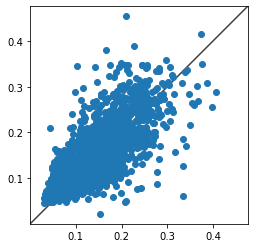

In [51]:
fig, ax = plt.subplots()
ax.scatter(actual, binom_results.fittedvalues)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)